In [1]:
import torch
from simulation_utils import run_simulation, plot_results, plot_total_dividends, calculate_total_dividends, Yuma, Yuma2
from cases import weights_epochs_cases

# Diagnostic of large validators clipping advantage effects on validators dividents
This notebook investigates the inherent advantage that large validators possess when it comes to dividend distribution. Specifically, we simulate scenarios on a 1-winner-takes-all subnet type. We aim to demonstrate that large validators receive higher dividends per 1,000 Tao staked, even when they do not take the initial risk to discover and support new miners.

### **Purpose**
- To highlight the disparity in dividend earnings between large and small validators.
- To show that large validators can "win" by earning more dividends per 1,000 Tao without taking the risk of supporting new miners early.
- To emphasize the challenges small validators face when trying to gain fair rewards for their proactive actions.

### **Scenarios Simulated**

We simulate three cases where validators switch their support to the new server (Server 2) at different times. The goal is to observe how the timing of support affects their dividends per 1,000 Tao staked.

### **Case 1**

- **Epoch 1:**
  - All validators support **Server 1** (initial consensus).
- **Epoch 2:**
  - **Validator C** (small validator) decides to take the risk and switches to **Server 2**.
  - Validators A and B continue supporting Server 1.
- **Epoch 3:**
  - **Validator A** (large validator) switches to Server 2.
  - Validator B continues supporting Server 1.
- **Epoch 4 onwards:**
  - All validators support Server 2.

### **Case 2**

- **Epoch 1:**
  - All validators support **Server 1**.
- **Epoch 2:**
  - **Validator A** switches to **Server 2** immediately.
  - Validators B and C continue supporting Server 1.
- **Epoch 3:**
  - **Validator B** switches to Server 2.
  - Validator C continues supporting Server 1.
- **Epoch 4 onwards:**
  - All validators support Server 2.

### **Case 3**

- **Epoch 1:**
  - All validators support **Server 1**.
- **Epoch 2:**
  - **Validator B** (small validator) takes the risk and switches to **Server 2**.
  - Validators A and C continue supporting Server 1.
- **Epoch 3:**
  - **Validator C** switches to Server 2.
  - Validator A continues supporting Server 1.
- **Epoch 4 onwards:**
  - All validators support Server 2.

### **Case 4**
- **Epoch 1:**
  - All validators support **Server 1**.
- **Epoch 2:**
  - **Both of small validators** (B and C) switching to support **Server 2**.
  - Validators C continues supporting **Server 1**.
- **Epoch 3:**
  - **Validator A** switches to **Server 2**.
- **Epoch 4 onwards:**
  - All validators support **Server 2**.
- **Epoch 41:**
  - **Validators A and B** switch to support **Server 1**.
- **Epoch 42:**
  - **Slowish validator V** switches back to **Server 1**.
- **Epoch 43 onwards:**
  - All validators support **Server 1**.

### **Case 5**
- **Epoch 1:**
  - All validators support **Server 1**.
- **Epoch 2:**
  - **Both of small validators** (B and C) switching to support **Server 2**.
  - Validators C continues supporting **Server 1**.
- **Epoch 3:**
  - **Validator A** switches to **Server 2**.
- **Epoch 4 onwards:**
  - All validators support **Server 2**.
- **Epoch 41:**
  - **Validators B** switches to support **Server 1**.
- **Epoch 42:**
  - **Validators C** switches to support **Server 1**.
- **Epoch 43:**
  - **Validators A** switches to support **Server 1**.
- **Epoch 44 onwards:**
  - All validators support **Server 1**.

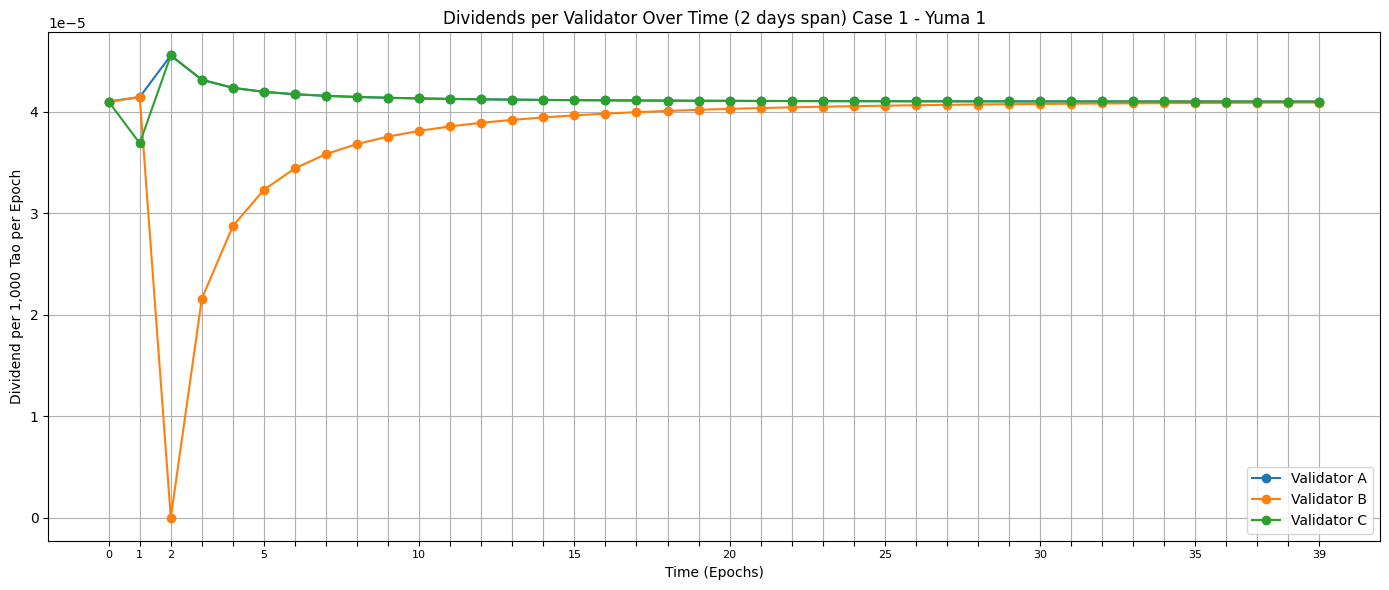

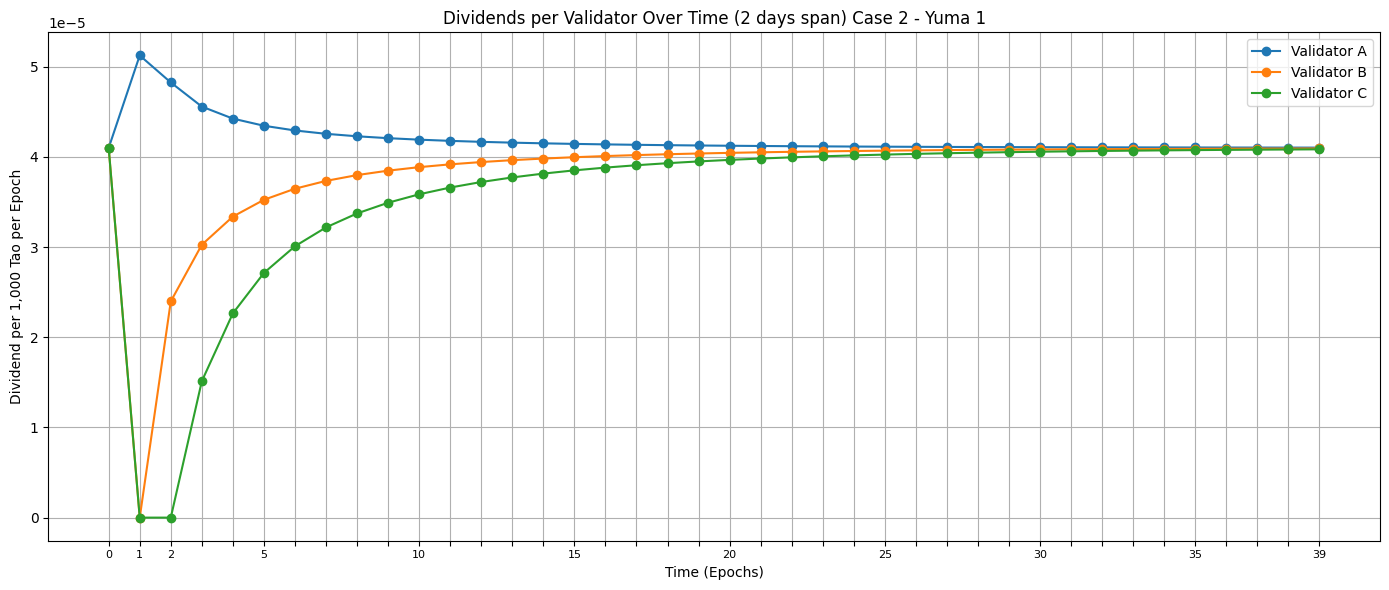

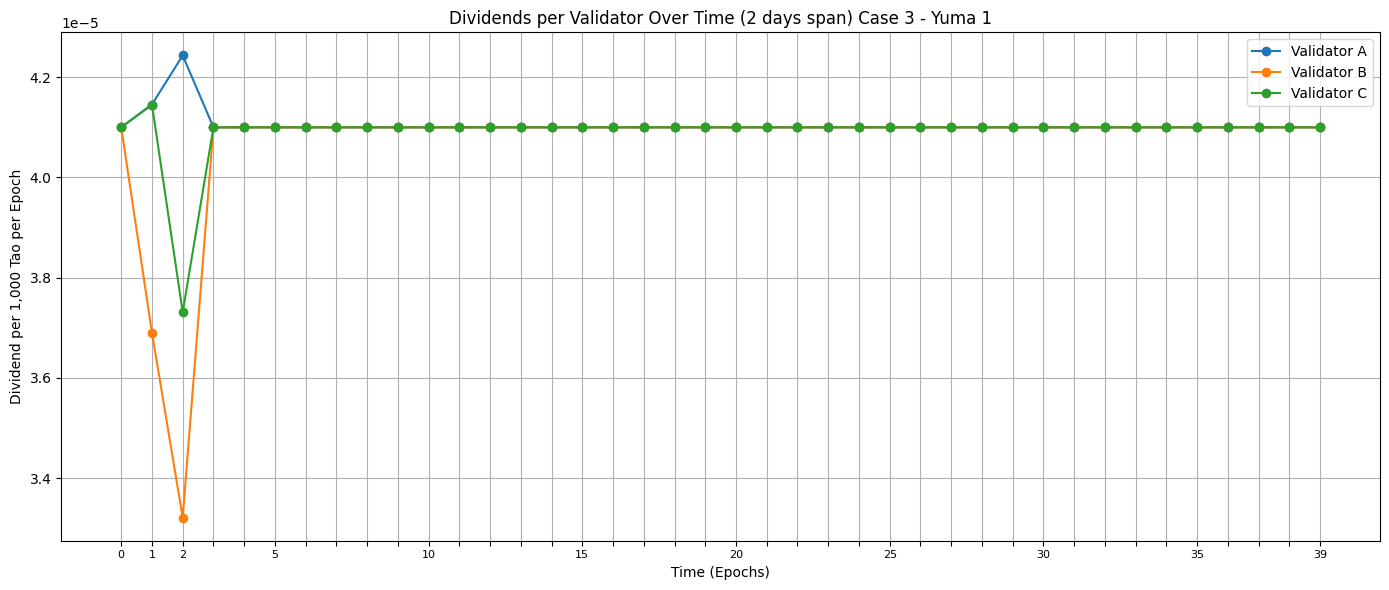

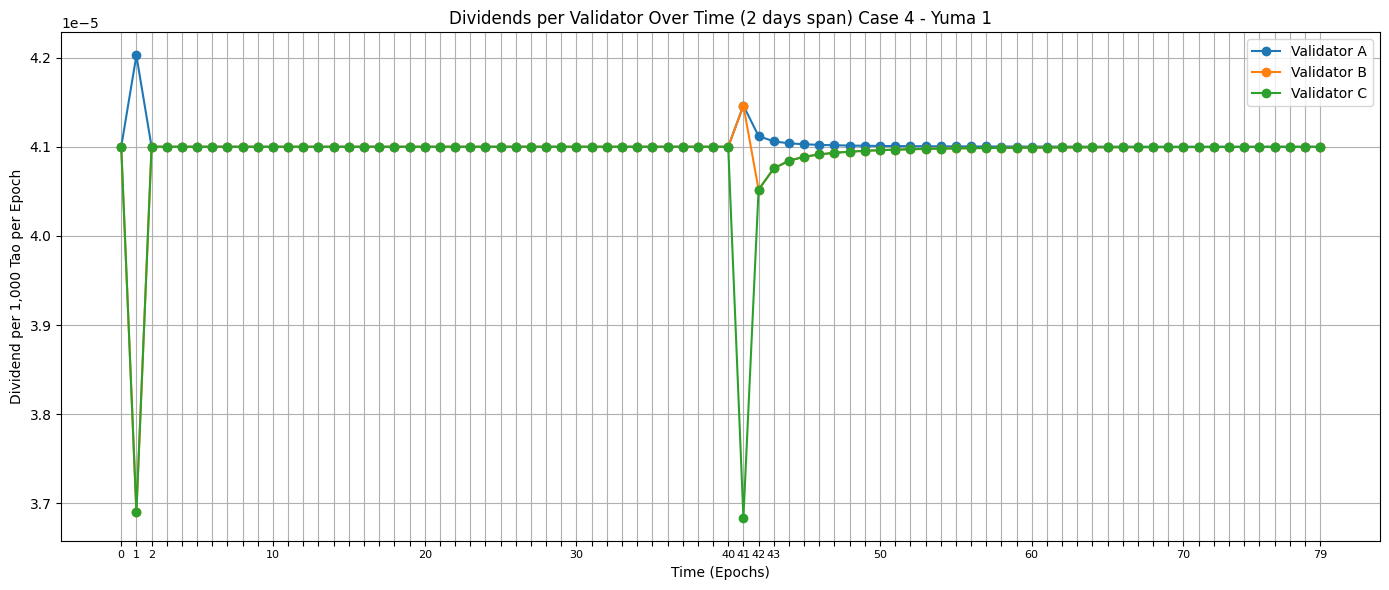

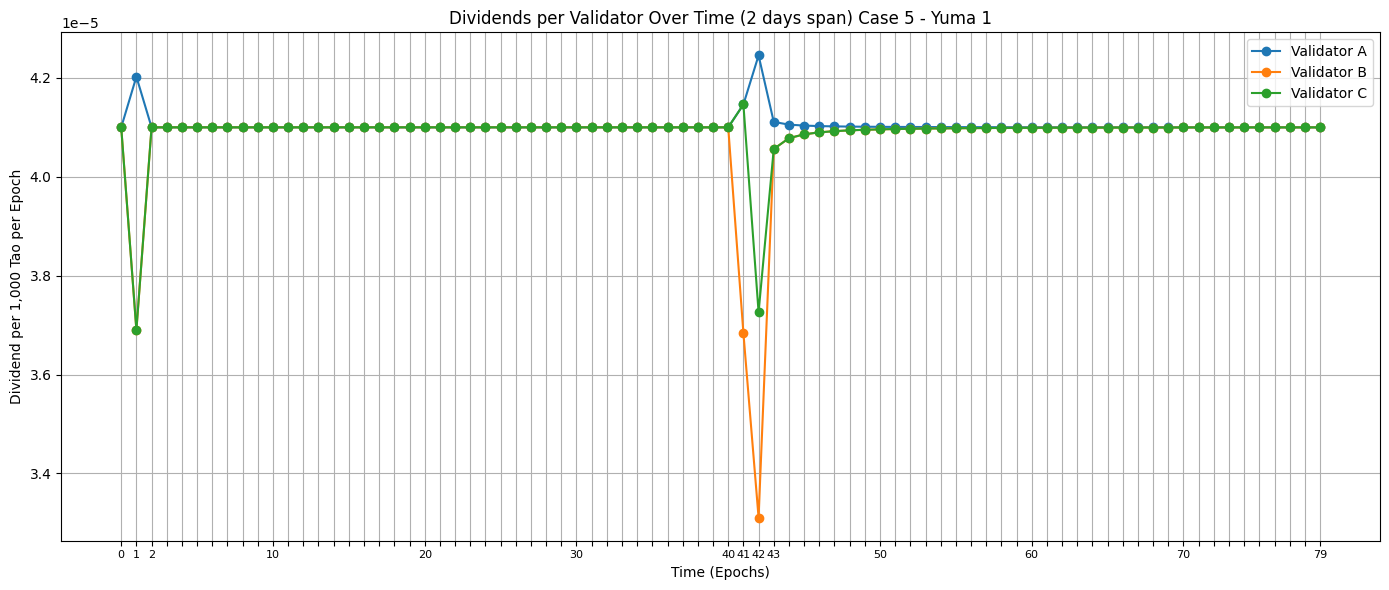

In [2]:
validators = ['Validator A', 'Validator B', 'Validator C']

servers = ['Server 1', 'Server 2']

total_emission = 100 # We assume this is the total emission in tao per epoch for the subnet

stakes = torch.tensor([0.8, 0.1, 0.1])
total_stake_tao = 1_000_000  # Total stake in the network
stakes_tao = stakes * total_stake_tao  # [800,000, 100,000, 100,000]
stakes_units = stakes_tao / 1_000  # [800, 100, 100]

cases = [
    {
        'name': 'Case 1',
        'num_epochs': 40,
        'weights_epochs': weights_epochs_cases['Case 1'],
    },
    {
        'name': 'Case 2',
        'num_epochs': 40,
        'weights_epochs': weights_epochs_cases['Case 2'],
    },
    {
        'name': 'Case 3',
        'num_epochs': 40,
        'weights_epochs': weights_epochs_cases['Case 3'],
    },
    {
        'name': 'Case 4',
        'num_epochs': 80,
        'weights_epochs': weights_epochs_cases['Case 4'],
    },
    {
        'name': 'Case 5',
        'num_epochs': 80,
        'weights_epochs': weights_epochs_cases['Case 5'],
    }
]

dividends_per_validator_list = []
for case in cases:
    case_name = case['name']
    num_epochs = case['num_epochs']
    weights_epochs = case['weights_epochs']
    dividends_per_validator = run_simulation(
        validators,
        stakes,
        stakes_tao,
        weights_epochs,
        num_epochs,
        total_emission,
        yuma_function=Yuma
    )

    plot_results(num_epochs, dividends_per_validator, f"{case_name} - Yuma 1")
    dividends_per_validator_list.append(dividends_per_validator)

### **Total Dividends After 30 Epochs**
We calculate the total dividends per 1,000 Tao staked for each validator after 30 epochs (1.5 days).

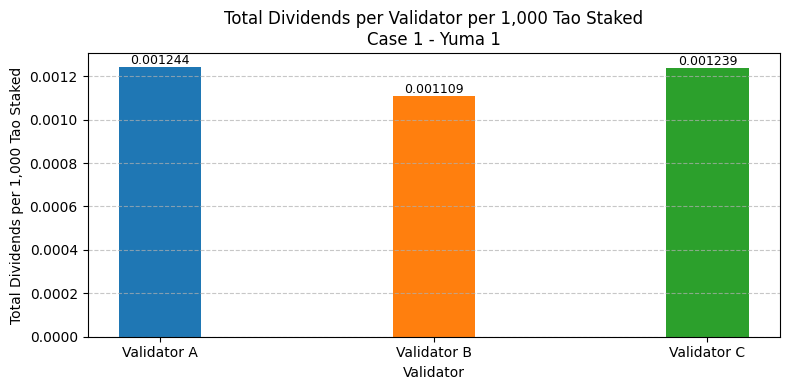

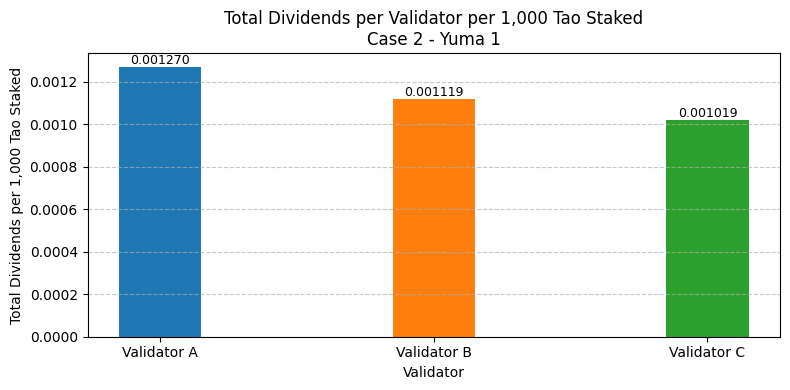

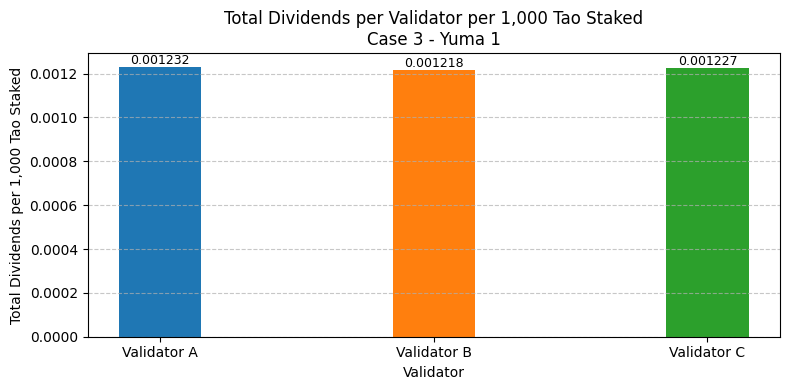

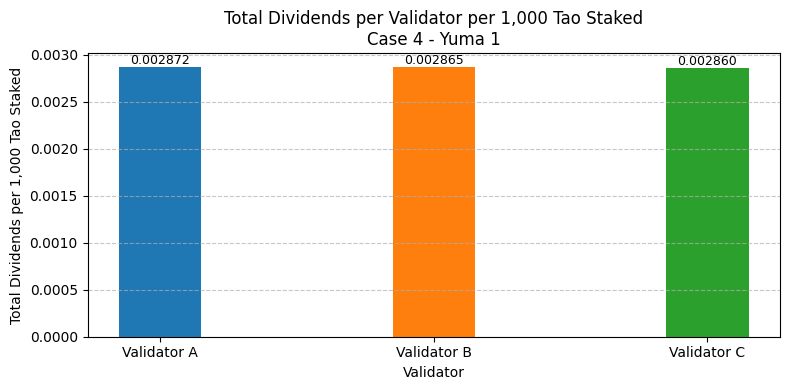

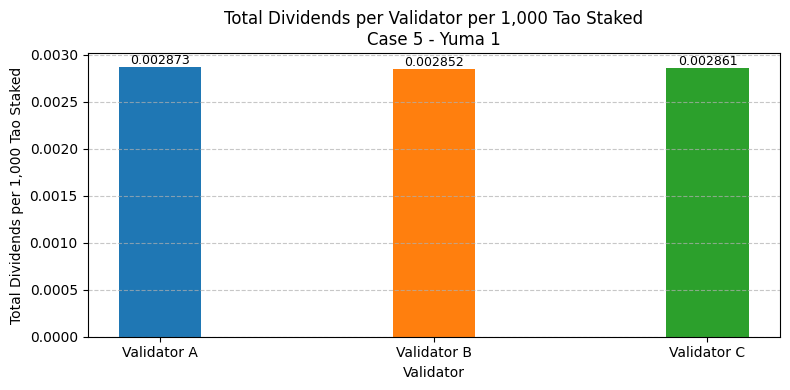

In [3]:
for dividends_per_validator, case in zip(dividends_per_validator_list, cases):
    case_name = case['name']
    num_epochs = case['num_epochs']
    num_epochs_summary = 30 if num_epochs == 40 else 70 #TODO introduce more meaningful way to calculate num_epochs=80
    total_dividends = calculate_total_dividends(
        validators,
        dividends_per_validator,
        num_epochs_summary
    )
    plot_total_dividends(total_dividends, f"{case_name} - Yuma 1", validators)

## **Results and Analysis**
In each scenario, the large validator (Validator A) ends up earning more dividends per 1,000 Tao than the smaller validators, even when they did not take the initial risk to support the new server.
### **Consensus Thresholds**
The network requires a certain threshold of stake-weighted support for a new miner to be accepted into the consensus. Large validators can effectively veto new miners by withholding their support, regardless of the miner's validity or potential benefits.
### **Clipping Mechanism Dynamics**
The clipping mechanism is designed to maintain network stability by favoring the opinions of validators with more stake. This design unintentionally sidelines small validators, preventing them from contributing meaningfully to network changes.

# Possible solution #1


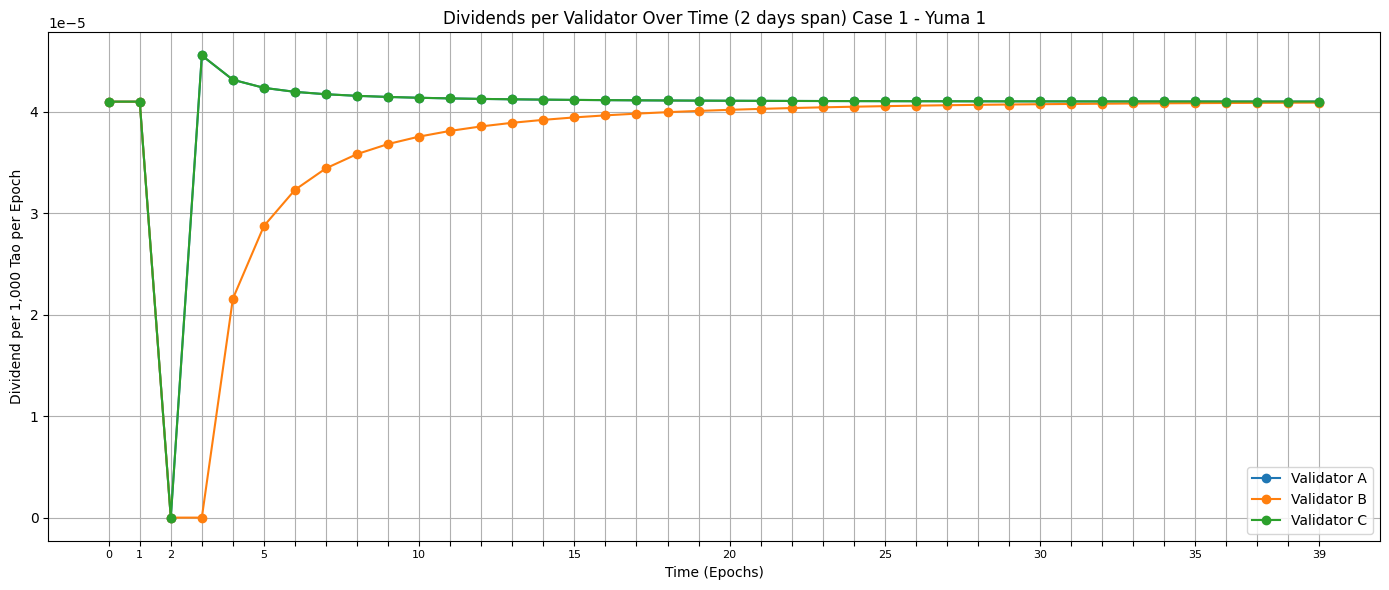

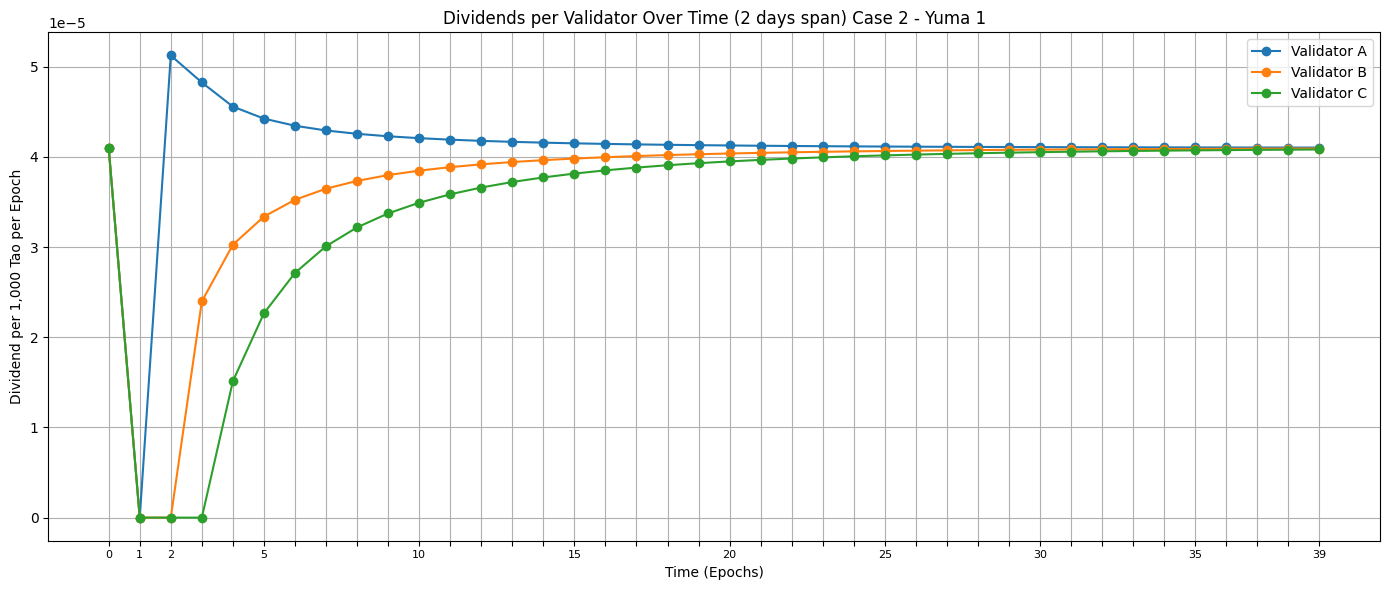

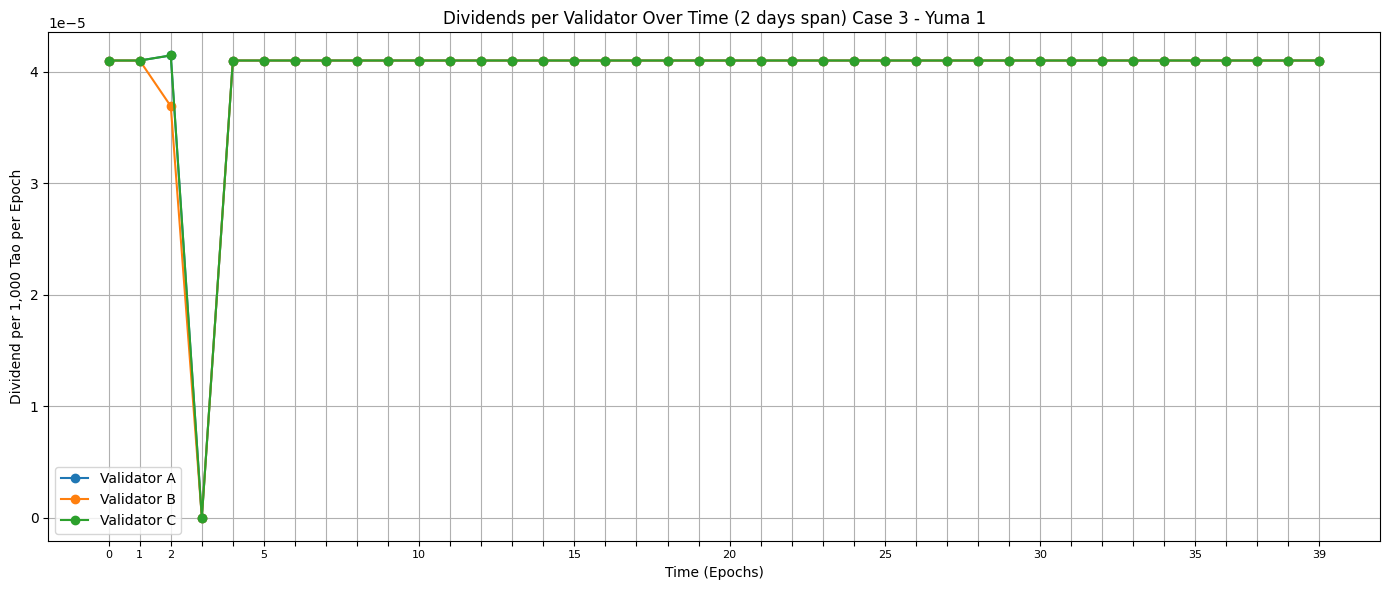

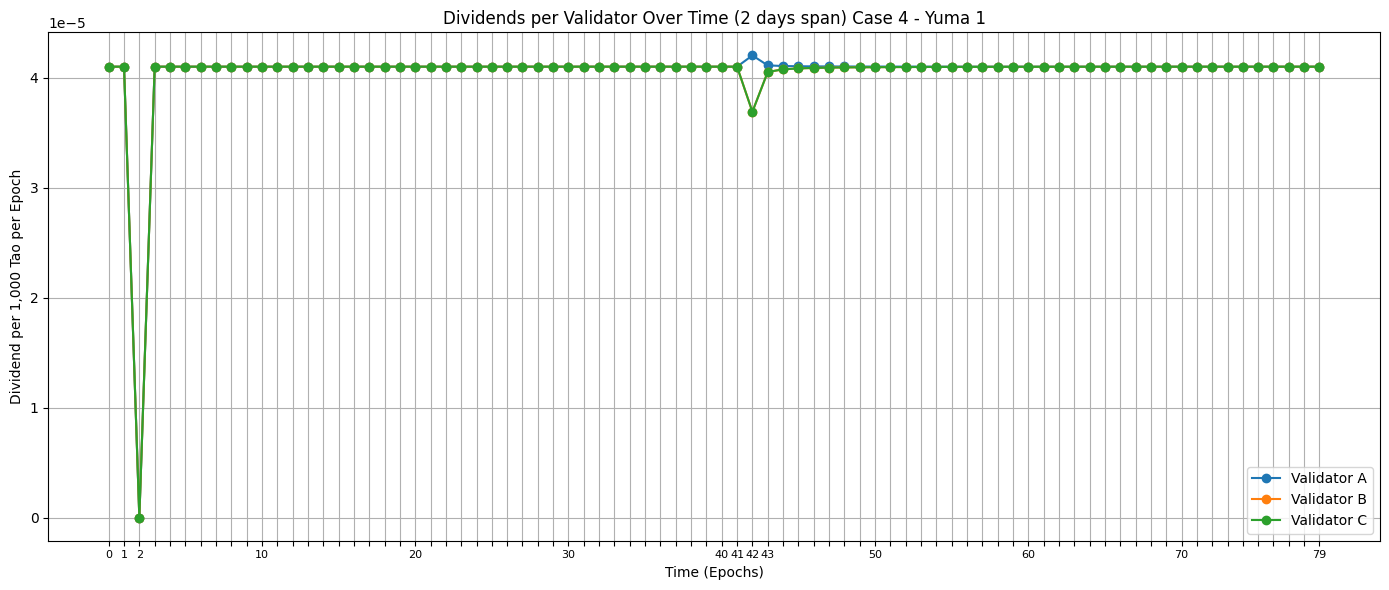

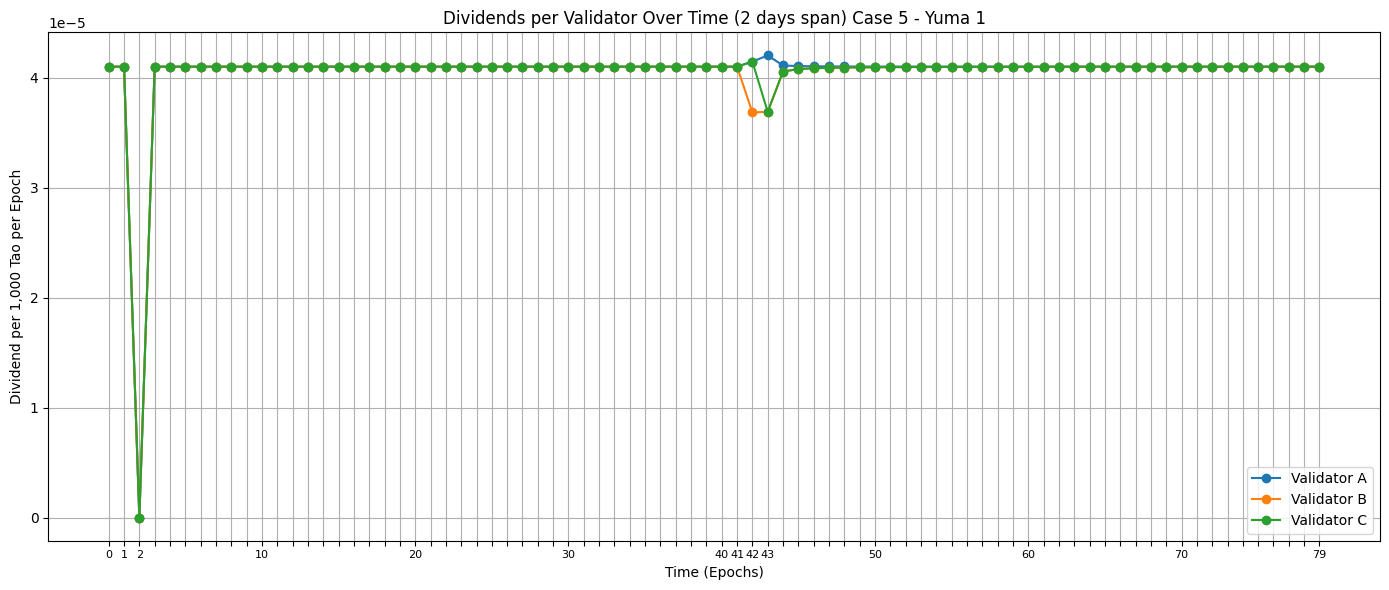

In [4]:
dividends_per_validator_list = []
for case in cases:
    case_name = case['name']
    num_epochs = case['num_epochs']
    weights_epochs = case['weights_epochs']
    dividends_per_validator = run_simulation(
        validators,
        stakes,
        stakes_tao,
        weights_epochs,
        num_epochs,
        total_emission,
        yuma_function=Yuma2
    )

    plot_results(num_epochs, dividends_per_validator, f"{case_name} - Yuma 1")
    dividends_per_validator_list.append(dividends_per_validator)

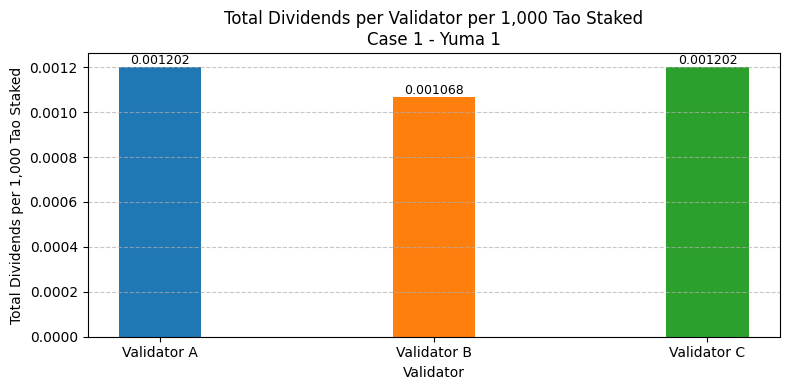

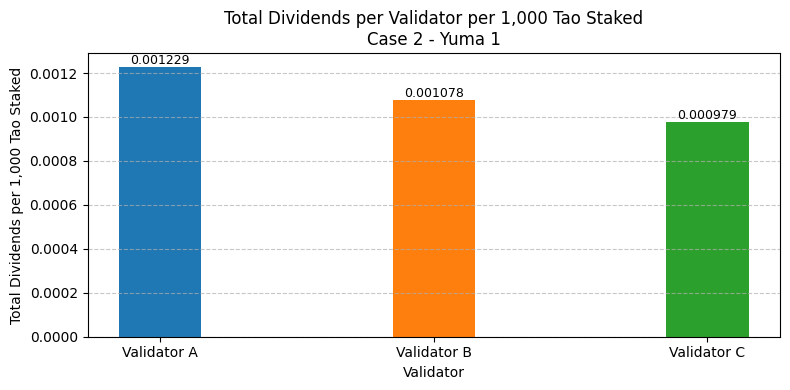

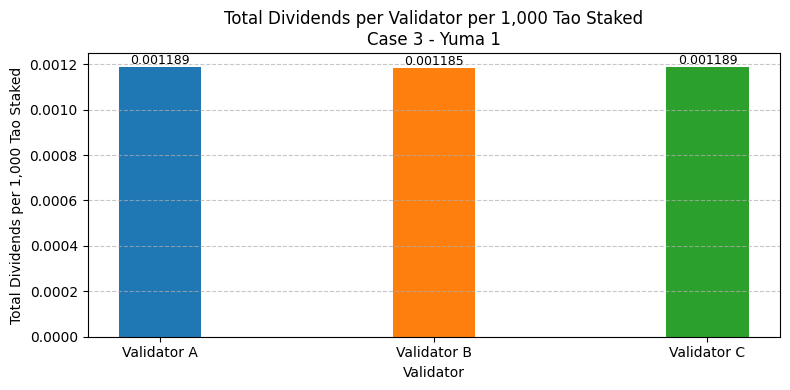

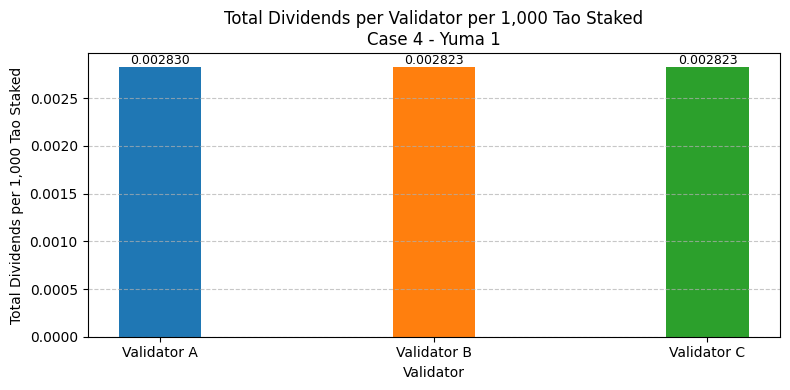

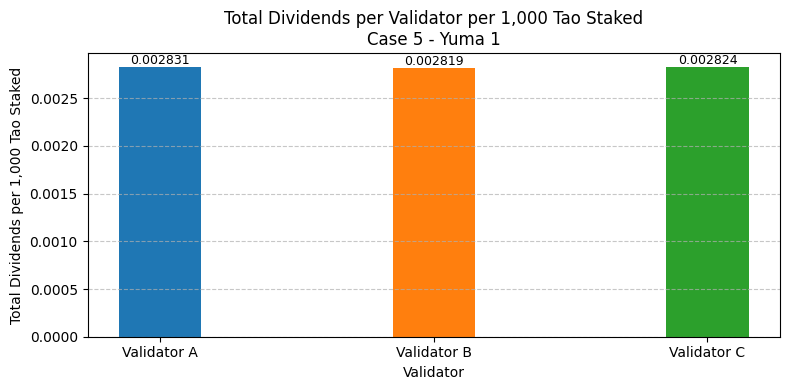

In [5]:
for dividends_per_validator, case in zip(dividends_per_validator_list, cases):
    case_name = case['name']
    num_epochs = case['num_epochs']
    num_epochs_summary = 30 if num_epochs == 40 else 70 #TODO introduce more meaningful way to calculate num_epochs=80
    total_dividends = calculate_total_dividends(
        validators,
        dividends_per_validator,
        num_epochs_summary
    )
    plot_total_dividends(total_dividends, f"{case_name} - Yuma 1", validators)